# Aim of code

Script for fitting disentanglement time at 298K using data at 600-800K.
No restriction of a parameter in curver fit.


In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
state='MSM2'
# # List of FPT at each temperature that protein unfold, Criteria: Q <= 0.3 for 1000 ps
FPT_dict = {
    'FPT_600' : np.array([ 7.35, 3.36, 3.21, 5.11, 12.13, 2.61, 8.41, -0.001, 5.41, 9.47, 4.99, 2.68, 3.54, 4.8, 7.25, 1.72, 2.79, 3.92, 7.07, 2.22, 3.04, 3.99, 11.61, 6.36, 2.93, 2.94, 5.64, 2.1, 9.08, 3.29, 2.91, 3.78, 3.76, 1.92, 3.2, 2.82, 7.52, 3.0, 4.61, 2.26, 4.48, 6.35, 8.49, 6.31, 6.21, 5.19, 5.81, 6.2, 2.62, 3.64]),
    'FPT_650' : np.array([ 1.8, 1.46, 1.62, 3.92, 0.83, 0.96, 1.6, 1.42, 1.35, 1.85, 0.98, 1.18, 1.1, 1.68, 1.24, 0.91, 1.03, 0.99, 1.92, 1.04, 1.64, 1.28, 2.01, 1.38, 1.6, 2.69, 1.45, 1.28, 1.8, 1.01, 2.51, 3.48, 0.67, 1.47, 2.46, 1.04, 1.86, 1.76, 2.04, 1.03, 2.21, 0.88, 1.87, 1.04, 1.04, 1.47, 1.52, 3.78, 1.33, 1.43]),
    'FPT_700' : np.array([ 0.83, 0.53, 0.69, 0.75, 0.8, 0.73, 0.9, 0.7, 0.52, 0.86, 0.59, 0.6, 0.48, 0.58, 0.6, 0.6, 1.13, 0.88, 0.5, 0.91, 0.96, 0.6, 0.79, 0.41, 1.07, 1.04, 0.76, 0.37, 0.51, 0.57, 0.62, 0.93, 0.51, 0.81, 0.47, 0.41, 0.71, 1.34, 0.62, 0.88, 0.61, 0.73, 0.76, 0.97, 0.49, 0.79, 0.61, 1.02, 1.1, 0.35]),
    'FPT_750' : np.array([ 0.32, 0.37, 0.49, 0.33, 0.35, 0.41, 0.49, 0.34, 0.52, 0.33, 0.36, 0.24, 0.28, 0.38, 0.34, 0.47, 0.5, 0.33, 0.43, 0.42, 0.4, 0.42, 0.49, 0.55, 0.43, 0.47, 0.45, 0.27, 0.37, 0.48, 0.36, 0.44, 0.34, 0.32, 0.62, 0.59, 0.41, 0.56, 0.38, 0.34, 0.58, 0.36, 0.49, 0.48, 0.35, 0.35, 0.45, 0.27, 0.34, 0.42]),
    'FPT_800' : np.array([ 0.23, 0.32, 0.25, 0.24, 0.37, 0.26, 0.48, 0.25, 0.23, 0.27, 0.22, 0.26, 0.29, 0.34, 0.21, 0.3, 0.21, 0.33, 0.23, 0.32, 0.23, 0.19, 0.17, 0.21, 0.27, 0.27, 0.21, 0.23, 0.2, 0.29, 0.23, 0.27, 0.24, 0.36, 0.18, 0.41, 0.3, 0.36, 0.27, 0.24, 0.26, 0.25, 0.34, 0.27, 0.24, 0.25, 0.27, 0.2, 0.29, 0.16])
}

In [3]:
# Matplotlib setting
fontsize = 12 # set variable for fontsize
linewidth = 2 # set variable for line width
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['axes.labelsize'] = 'small'
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 4
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['xtick.labelsize'] = 'x-small'
matplotlib.rcParams['ytick.labelsize'] = 'x-small'
matplotlib.rcParams['legend.fontsize'] = 'x-small'
matplotlib.rcParams['figure.dpi'] = 600

# config for matplotlib
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.linewidth'] = 2 #set the value globally

# set tick width
matplotlib.rcParams['xtick.major.size'] = 6
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.major.width'] = 2

In [4]:
"""
Functions definition
"""


def cal_Su_list(first_time_zero, time_end, dt=0.01):
    """
    Calculate the survival probability.

    Parameters:
    - first_time_zero (array-like): Array of first passage times.
    - time_end (float): The end time for calculating the survival probability.
    - dt (float, optional): Time step for the calculation. Default is 0.01.

    Returns:
    - ts (numpy.ndarray): Array of time points.
    - survival_probability (numpy.ndarray): Array of survival probabilities corresponding to the time points.
    """
    time_range = np.arange(0, time_end, dt)
    survival_probability = np.array([np.count_nonzero(first_time_zero >= t) / len(first_time_zero) for t in time_range])
    return time_range, survival_probability

def exp_fun(x, k, t0):
    """
    Exponential function used for fitting survival probability.

    Parameters:
    - x (numpy.ndarray): Time variable.
    - k (float): Rate constant.
    - t0 (float): Time offset.

    Returns:
    - numpy.ndarray: The value of the exponential function at time `x`.
    """
    t = x - t0
    t[t < 0] = 0
    return np.exp(-k * t)

def quadratic_fun(x, a, b, c):
    """
    Quadratic function for fitting purposes.

    Parameters:
    - x (numpy.ndarray): Independent variable (1/T).
    - a (float): Quadratic term coefficient.
    - b (float): Linear term coefficient.
    - c (float): Constant term.

    Returns:
    - numpy.ndarray: The value of the quadratic function at `x`.
    """
    return a * x**2 + b * x + c

def get_ln_kapp(FPT):
    """
    Calculate the natural logarithm of the apparent rate (ln_kapp) from the first passage time (FPT) array.

    Parameters:
    - FPT (array-like): First passage time array.

    Returns:
    - float: The natural logarithm of the apparent rate (ln_kapp).
    """
    time_end = np.max(FPT) + 5
    ts, Su_list = cal_Su_list(FPT, time_end)
    kopt, _ = curve_fit(exp_fun, ts, Su_list, bounds=(0, np.inf), maxfev=5000)
    k, t0 = kopt[0], kopt[1]
    kapp = 1e9 / (t0 + 1 / k)
    return np.log(kapp)


def write_SU(FPT, Temp):
    time_end = np.max(FPT) + 5
    ts, Su_list = cal_Su_list(FPT, time_end)
    with open(f'survival_{Temp}.dat', 'w') as f:
        for t, s in zip(ts, Su_list):
            f.write(f'{t:.2f}    {s:.3f}\n')

            

            
def bootstrap_FPT_dict(Temperature_FPT_dict):
    # Create a new dictionary for the random choices
    random_FPT_dict = {}

    # Apply np.random.choice with replacement to each array in the original dictionary
    for key in Temperature_FPT_dict:
        random_FPT_dict[key] = np.random.choice(Temperature_FPT_dict[key], size=len(Temperature_FPT_dict[key]), replace=True)

    # Print the new dictionary with random choices
#     print(random_FPT_dict)
    return random_FPT_dict

def extrapolate_ln_kapp_target_temperature(temperature_list, Temperature_FPT_dict, target_temp=298):
    """
    Extrapolates the natural logarithm of kapp (ln(kapp)) for a target temperature using quadratic fitting.
    
    Parameters:
    temperature_list (list of float): List of temperatures to be used for fitting.
    Temperature_FPT_dict (dict): Dictionary containing FPT values for each temperature. Keys should be formatted as 'FPT_<temperature>'.
    target_temp (float, optional): The target temperature for which ln(kapp) is to be extrapolated. Default is 298 K.
    
    Returns:
    tuple: 
        - numpy.ndarray: Inverse temperatures including the target temperature.
        - numpy.ndarray: ln(kapp) values including the extrapolated value for the target temperature.
        - float: Coefficient of determination (R^2) for the quadratic fit.
        - numpy.ndarray: Coefficients of the quadratic function (a, b, c).
    """
    # Initialize an array to store inverse temperatures and ln(kapp) values
    num_temperatures = len(temperature_list)
    inv_temperature_ln_kapp = np.zeros((num_temperatures + 1, 2))
    
    for i, temperature in enumerate(temperature_list):
        inv_temperature_ln_kapp[i, 0] = 1/temperature
        inv_temperature_ln_kapp[i, 1] = get_ln_kapp(Temperature_FPT_dict[f'FPT_{temperature}'])
        
    # Fit a quadratic function to the data points (excluding the target temperature)
    kopt_target, _ = curve_fit(quadratic_fun, inv_temperature_ln_kapp[:-1, 0], inv_temperature_ln_kapp[:-1, 1], maxfev=5000)
    
    # Calculate the coefficient of determination (R^2) for the fit
    predicted_ln_kapp = quadratic_fun(inv_temperature_ln_kapp[:-1, 0], *kopt_target)
    cc_target = np.corrcoef(inv_temperature_ln_kapp[:-1, 1], predicted_ln_kapp)[0, 1] ** 2
    
    # Extrapolate ln(kapp) for the target temperature
    ln_kapp_target = quadratic_fun(1 / target_temp, *kopt_target)

    # Add the target temperature and its extrapolated ln(kapp) value to the array
    inv_temperature_ln_kapp[-1,:] = 1/target_temp, ln_kapp_target
    return inv_temperature_ln_kapp[:, 0], inv_temperature_ln_kapp[:, 1], cc_target, kopt_target


def convert_ln_kapp_to_human(ln_kapp, human_type='day'):
    """
    Convert the logarithm of kapp (ln_kapp) to human time.

    Parameters:
    - ln_kapp (float): The natural logarithm of kapp.
    - human_type (str): The desired unit of human time. Can be 'second', 'hour', or 'day'. Default is 'day'.

    Returns:
    - float: The converted time in the specified human time unit.
    """
    # scaled_factor = 143
    
    # Calculate the simulated life time in nanoseconds
    simulated_life_time = 1 / np.exp(ln_kapp)
    
    # Convert simulated life time from nanoseconds to human time
    conversion_factors = {
        'second': 1,
        'hour': 1 / 3600,
        'day': 1 / 86400
    }
    
    if human_type not in conversion_factors:
        raise ValueError("Invalid human_type. Expected one of: 'second', 'hour', 'day'")

    lifetime = simulated_life_time / conversion_factors[human_type]
    return lifetime


In [5]:
target_temp = 298
temperature_list = [800, 750, 700, 650, 600]

In [6]:
mean_res = extrapolate_ln_kapp_target_temperature(temperature_list, FPT_dict)

In [7]:
# bootstrapping
nboot=10000
i=0
ln_kapp_array = np.zeros((len(temperature_list)+1, nboot))
while i < nboot:
    random_FPT_dict = bootstrap_FPT_dict(FPT_dict)
    res = extrapolate_ln_kapp_target_temperature(temperature_list, random_FPT_dict, target_temp)
    print(res[2], res[1][-1])
    if res[2] >= 0.9:
        print(i)
        ln_kapp_array[:,i] = res[1]
        i+=1
    

0.9997793730479774 -11.550032416686413
0
0.9984425296173393 -7.964652068715431
1
0.9999978910648885 -9.541169030440184
2
0.9991347570499838 -12.963673674173588
3
0.9998438927371874 -12.46160927869008
4
0.9996752290642646 -13.522774272174335
5
0.9998018322531401 -11.605423531430457
6
0.9992237753603797 -11.505247741157568
7
0.9998008647518616 -19.697901475780426
8
0.9989447276173051 -11.768357514531026
9
0.9987612153664481 -15.18006496626968
10
0.9999069021413073 -11.205097938233525
11
0.9985349995278573 -8.956347588044043
12
0.9978881928082892 -23.90932526583635
13
0.9996872298905474 -13.030447556606685
14
0.9997966576021095 -17.60286839634792
15
0.9993876641154201 -20.398993077835073
16
0.9999539365603476 -8.112568139477258
17
0.9999897423716434 -11.13977605431661
18
0.9990727960503818 -17.99991976862303
19
0.9995198937855388 -7.149239814625247
20
0.9979808576764252 -12.524698864247018
21
0.9993737163238446 -1.8703986569950253
22
0.9997916882351023 -14.582813481337954
23
0.99917906728

0.9983232768379204 -33.364843299015256
398
0.9984822067829784 -40.32323508632085
399
0.9990383336081975 -36.286357244991336
400
0.9992628074736466 -29.097644790146216
401
0.999957366644267 -32.83180762410596
402
0.9971001010927415 -26.819562952299247
403
0.997157703823327 -41.621281437764864
404
0.9999731731363959 -29.06289733736677
405
0.998050370995072 -29.15571749227583
406
0.9999383819902083 -34.90597879339742
407
0.9993209823445309 -31.269621690125657
408
0.9992540736305683 -34.31524012607831
409
0.9983633498615327 -28.983033629773395
410
0.9983761963975071 -28.58846330047758
411
0.9999225253371549 -32.87773328905517
412
0.9986667240015422 -26.69646938898445
413
0.9992897234663118 -31.065384556722606
414
0.9986931179667652 -37.44079121859174
415
0.999278574480843 -39.45252710730305
416
0.9996556023093901 -35.54217099229359
417
0.9992653192430365 -32.04638739641219
418
0.9999247679077157 -33.199916348237956
419
0.9998967623992767 -29.71984411642128
420
0.9997587905453562 -31.518845

0.9997425674051515 -35.5751998697904
593
0.9998460876357603 -27.53167016491515
594
0.9949092349217391 -37.315734494440704
595
0.9979732521725904 -39.05829426547534
596
0.9997807387678953 -40.29337847403588
597
0.9995645304370439 -29.235702374198244
598
0.9999960430901645 -35.1858612105049
599
0.9992756661686912 -31.3091102492589
600
0.9999750006131106 -27.99141890698594
601
0.9993836561448423 -29.962964774300644
602
0.9999662218400132 -34.03183180641729
603
0.9989760729415768 -28.148030934178355
604
0.9974877671687267 -30.72422039068963
605
0.9954555745720287 -33.113742791261
606
0.9998253736341054 -38.748252455059344
607
0.9977984683548955 -37.644923938406194
608
0.9998602855877609 -35.127854226053586
609
0.9990029549930869 -33.2558761473842
610
0.9990567613792297 -31.020161710623494
611
0.9990505483834451 -31.655918258718895
612
0.9993810408103609 -39.85016948253815
613
0.9996252737886774 -38.42117083812096
614
0.9997275293272362 -38.30738374426094
615
0.9994749819805532 -33.56664264

0.9997577157436389 -33.64397061939409
789
0.9985544783780066 -33.404467435649885
790
0.9996247310526457 -28.85786023011027
791
0.9994288828713792 -33.324624604289056
792
0.9995135911077105 -37.15157507422967
793
0.9966870863078079 -41.39469924286718
794
0.9997428105531834 -29.390446496681186
795
0.9992948004896172 -22.953469881251074
796
0.9980595613568125 -36.33534221666086
797
0.9988352694259474 -34.04459659939612
798
0.9996376060408805 -32.40410793003308
799
0.9995052457284921 -37.59700345325566
800
0.999779421897385 -31.672048131013476
801
0.9990695107471719 -41.08086238696703
802
0.9989199013228212 -31.042822314267543
803
0.9998095877193882 -37.37315909906805
804
0.9967269763654201 -39.668404090286536
805
0.9999503100253161 -31.331087894065988
806
0.9987496523402271 -35.698873850286745
807
0.9987300969864977 -25.799129555200288
808
0.9988248195347852 -38.64355659085822
809
0.9990814891265605 -37.71099196218861
810
0.9990513165006196 -32.128263141519106
811
0.9999030598446036 -27.2

0.9994103589264861 -40.78387890451779
988
0.9992434725471223 -34.39078164624595
989
0.9995849037324116 -41.354328226822375
990
0.998504297092928 -31.75207267288206
991
0.9995551829111704 -34.684970140495416
992
0.9983917388372925 -32.37662253026028
993
0.9989893997816166 -40.12930723339278
994
0.9972281101137299 -36.75982816171507
995
0.9996260586443607 -34.59504438946385
996
0.9968970417978374 -41.237398368442626
997
0.9999055921597813 -37.34173122166263
998
0.9995473780323639 -34.220635592928964
999
0.9991489727473662 -35.52167659707343
1000
0.999388208976339 -38.524373310494255
1001
0.9986782544496903 -40.370095906134914
1002
0.9992691471112426 -39.105635567774726
1003
0.9990371420461734 -40.524576231652624
1004
0.9996380239783622 -33.698625404660746
1005
0.9999439499646471 -22.894413124852285
1006
0.9981951827015334 -30.750119348484183
1007
0.9996254732931532 -37.52758687898618
1008
0.9990884313799034 -39.4829863253106
1009
0.9997513371282956 -27.612452270304683
1010
0.999417686901

0.9991165688387799 -40.61556544702983
1178
0.9999027741625294 -33.079022462191006
1179
0.999420476339939 -40.28624311984756
1180
0.998659369580744 -31.689049494467504
1181
0.9991841528980768 -33.28559741367884
1182
0.9976735466037973 -25.16807797226268
1183
0.9997526443360186 -31.24708578058267
1184
0.9980824275015544 -31.60051337533825
1185
0.9987171249600286 -36.03819542945255
1186
0.9984952370276312 -37.31322476025573
1187
0.9998391680052359 -47.382935247469035
1188
0.9983281605824944 -34.24534902289117
1189
0.9991573722669853 -34.387295495202544
1190
0.9998886742024959 -36.39154340577653
1191
0.9997187526731868 -28.452685576727063
1192
0.999954421546161 -33.67842252198775
1193
0.9980696818775874 -42.45685875975594
1194
0.9991392675329088 -25.79756832588167
1195
0.9998713761410579 -39.966996940190995
1196
0.9993157624065497 -27.348788603799314
1197
0.9997981195491857 -26.96297898390212
1198
0.999721228761406 -31.499968430734985
1199
0.9999708727755341 -39.72220351240511
1200
0.99983

0.9992963559775674 -30.898700216696707
1369
0.9999147854522217 -39.23677420982852
1370
0.9997933842399561 -38.067909143673376
1371
0.99937111453034 -30.509385788139497
1372
0.999795120105617 -31.39160937659089
1373
0.9989893737292384 -34.6947619566561
1374
0.9979967756772753 -25.6699731796046
1375
0.9983544094134218 -29.582495648437245
1376
0.9983950759486772 -25.795880982611145
1377
0.9997739633834937 -35.580072058403985
1378
0.9995971337139207 -42.56193540031309
1379
0.9993530410457523 -43.03171190249541
1380
0.9976952501800957 -30.834752489288814
1381
0.9968714597270069 -32.332406639563104
1382
0.9998908154615846 -35.72784886665597
1383
0.9980952763301058 -40.59547189699385
1384
0.998516422493134 -40.79002048158763
1385
0.9986604047529068 -31.38944086505146
1386
0.9999737061582458 -27.9972481235039
1387
0.9994842292216974 -34.675933987964335
1388
0.9993776363600787 -35.28962714760986
1389
0.9935757760916394 -44.71070417690686
1390
0.998194343497671 -29.245501945625392
1391
0.9999529

0.9998960964554693 -22.240121114326747
1560
0.9999664993904999 -31.33118024443633
1561
0.999216802139067 -33.8803683586067
1562
0.9992804102599883 -29.889460251459784
1563
0.999509024825317 -41.108481227529616
1564
0.9970500053005459 -35.34961680108653
1565
0.9989287834338134 -21.638093466535246
1566
0.9978128523395557 -35.12577757713324
1567
0.9978803765629036 -40.02379939021044
1568
0.9997717640351265 -31.454257915849734
1569
0.9985592641684384 -30.061977167742338
1570
0.9995403339037753 -31.823060623574303
1571
0.9997236206113691 -32.21697022525539
1572
0.9981033611880648 -20.942202540074433
1573
0.9999998494975916 -33.8770023057944
1574
0.9999335665606914 -43.602999867273525
1575
0.9998168530111582 -41.64062856668924
1576
0.9994151849075376 -33.40914424821776
1577
0.9971956264854501 -38.48717351840163
1578
0.9998231721582856 -32.863513167009515
1579
0.9987453447541904 -29.527210066936192
1580
0.9975576589498173 -43.5996444589921
1581
0.9983462551155291 -30.321591876732537
1582
0.99

0.9995040852613168 -25.362708821940934
1750
0.9996745497705204 -35.77376666448089
1751
0.9980066472144797 -29.18195532515843
1752
0.9979058398660089 -42.56164123116305
1753
0.9996447326980517 -40.61935587496258
1754
0.9999133739797922 -36.85433665694363
1755
0.9998393477927693 -36.880928325926455
1756
0.9992129600023445 -32.77684544132509
1757
0.9993023334668406 -25.177118381082686
1758
0.9998361974996367 -34.54988149039157
1759
0.9993200860837504 -42.32419015987414
1760
0.99938905386323 -31.603040414929133
1761
0.9999341630239109 -27.043102652111813
1762
0.9998486784767784 -32.48570436110788
1763
0.9991955325443947 -40.84933800026452
1764
0.9991167125207833 -38.40996145405575
1765
0.999768977642695 -29.075073195394065
1766
0.9996865500206513 -34.98832136971303
1767
0.9981916088313212 -42.54129563689629
1768
0.9999832069288225 -29.103731871104277
1769
0.9996574008781789 -24.79807653822306
1770
0.9999441010566538 -21.046104783825747
1771
0.997917510821972 -35.21302958036355
1772
0.99903

0.9996303896216331 -30.00736854939177
1945
0.9983901841547355 -42.12877680208086
1946
0.9998149203750389 -35.674976015839114
1947
0.9998591160010284 -20.963799137170987
1948
0.9993697902144024 -26.824423708468878
1949
0.9985459697405815 -35.06026052003877
1950
0.9994793176590816 -25.625909126364828
1951
0.9983206223623303 -26.433522975061738
1952
0.9984665364543235 -35.12131629075844
1953
0.9986531837123676 -33.648850753339076
1954
0.9995803198570089 -37.80587286017269
1955
0.9999249302167945 -23.119942464811526
1956
0.9991813985422021 -37.8208661973772
1957
0.9991690095534276 -36.17210180237503
1958
0.9997600625729972 -29.577851622701996
1959
0.9988984932130206 -32.53667871831659
1960
0.9995534854345983 -33.52641222069878
1961
0.998709158167465 -41.913533081088026
1962
0.9982398327001745 -44.767002206251675
1963
0.999960474189805 -34.65548404965094
1964
0.9995401863872616 -28.79621622178313
1965
0.9995298377191655 -37.04787636539661
1966
0.9981748360499599 -33.40118163341076
1967
0.99

0.9978451179547261 -43.352636072127495
2137
0.9986643219254279 -40.67850815150153
2138
0.9992417636342135 -36.873957884872624
2139
0.9999563596428868 -32.50890961981885
2140
0.9998296636229861 -33.94002463582823
2141
0.9989851842096005 -33.565087974450286
2142
0.9998919910787797 -36.229262845417736
2143
0.9996747508423264 -30.997189378591408
2144
0.9998312326813016 -29.427827297644434
2145
0.9968157920941525 -28.020818775725996
2146
0.9998222363636009 -30.708843420554764
2147
0.9995414635947698 -43.44433470599745
2148
0.9993891071080677 -23.023223113383178
2149
0.9996253770588854 -29.30735492166648
2150
0.9977701375191088 -43.02638969935513
2151
0.9995031291283507 -28.771053287116466
2152
0.9991872450619879 -27.194384396792938
2153
0.9998855372415996 -30.187738822844956
2154
0.9986875492457471 -27.887649876319937
2155
0.9996396997154864 -37.01492949051863
2156
0.999604677832553 -29.869928261526127
2157
0.9998871698952757 -31.784222785181537
2158
0.9993762196664819 -42.38152763144617
21

0.996260051955806 -32.78333297840304
2327
0.9994053853788712 -34.30333648773737
2328
0.9994731274003171 -32.789411484034275
2329
0.9954994442967964 -33.265994531704564
2330
0.997266149923453 -20.306165645045
2331
0.9994895924351558 -34.366770861283364
2332
0.998380909329928 -38.811840454430794
2333
0.9996019826236174 -32.55495645730955
2334
0.9996692121312373 -29.375842690771382
2335
0.9999482482235696 -36.95120973903596
2336
0.9970202997229912 -27.33316566904378
2337
0.9982643296788896 -38.944626698803816
2338
0.9979309737818143 -39.817000763478475
2339
0.9957491509840569 -36.81124368212858
2340
0.9993914547895696 -32.21454509800363
2341
0.9996742081264218 -31.91805810225093
2342
0.999278614893923 -42.78121596927629
2343
0.9998046797926721 -29.141629902408425
2344
0.9987773959425206 -28.763699458817023
2345
0.9996826543602011 -38.63084347517859
2346
0.9996025911412825 -36.15320652880617
2347
0.9994056542612654 -39.138716294710285
2348
0.99780590551702 -33.085244635321075
2349
0.999422

0.9997904272435074 -37.19084801255165
2519
0.9990367621439498 -30.318469090502823
2520
0.9997898037172723 -31.812411736514694
2521
0.9986342713744958 -29.914697650391503
2522
0.9951913831331206 -34.452581160212596
2523
0.999887487825975 -34.178970362012684
2524
0.9998231337580933 -44.636439321626824
2525
0.9998993502205884 -40.75229129189329
2526
0.9969092464876604 -32.9340876803051
2527
0.9991187563701606 -37.615154841908954
2528
0.9976884939361766 -38.38350354211849
2529
0.9999491804942322 -38.72776783368921
2530
0.9997145785502815 -28.33757714879707
2531
0.9999115856613374 -42.46169609919476
2532
0.9987909598767499 -34.52715364749394
2533
0.9999316786500909 -27.391272602759503
2534
0.9986574188091281 -44.677640720586076
2535
0.9995504141631898 -33.91552994542931
2536
0.9998797804061628 -33.24178784280741
2537
0.9999457584380131 -33.502190828306354
2538
0.9980794742448402 -30.93546383274894
2539
0.999839194074 -36.8352649597367
2540
0.99919399965496 -35.7244518282089
2541
0.999960212

0.9988600977307627 -42.373257377378515
2713
0.9959139133512128 -37.30018200941925
2714
0.9981338865184298 -36.388023854403805
2715
0.9994951395446088 -37.76829388826904
2716
0.9998663507884731 -35.32931979581191
2717
0.998526964649673 -26.671380521254694
2718
0.9994975835136496 -32.626123375084525
2719
0.9999707965673192 -36.35093307636501
2720
0.998568511147673 -37.77596601466933
2721
0.9999287876817312 -34.317816063842656
2722
0.9998559764137913 -35.065185832553695
2723
0.9991409089475091 -25.56324079950307
2724
0.9999399120159016 -26.782443509407674
2725
0.9986445197348996 -33.18625424269019
2726
0.99733985644247 -25.22405645404497
2727
0.9981376612644905 -41.28529248630619
2728
0.9990703902893445 -41.73239319651114
2729
0.9993756779038473 -30.740333684705355
2730
0.9983219177440184 -42.577112006898155
2731
0.9998225254600351 -39.678390201586986
2732
0.9964226482096674 -31.877955548314354
2733
0.9997126987445814 -31.151437247660837
2734
0.9999942022508885 -30.050185861859397
2735
0.

0.9993701418376959 -40.32474749664019
2907
0.9969585444738689 -32.74324284232716
2908
0.9990634126481177 -39.39230753021373
2909
0.9985332918116321 -38.767551531791426
2910
0.9993911916916172 -34.736269078247076
2911
0.9999139383064846 -29.296373678367917
2912
0.9986606024170394 -31.436896443066875
2913
0.9982846862383569 -48.02411169655841
2914
0.9963827608446045 -35.93578662974261
2915
0.9996715742773579 -31.044789791476195
2916
0.999689996002196 -23.66640747738491
2917
0.9953308439011145 -42.05564583379673
2918
0.9985451665707031 -28.610607015949164
2919
0.9997170251418498 -32.64264605158125
2920
0.9996531952366753 -31.4934973373003
2921
0.9975661222772777 -29.32466767513761
2922
0.9996555158125505 -34.103651006000455
2923
0.9996096496715074 -25.779156797584296
2924
0.9989022313715821 -28.05825234544256
2925
0.9998882767711027 -38.197236209018996
2926
0.9988339271935648 -25.508738880600863
2927
0.9982939389777932 -38.4685573953538
2928
0.9999228809284341 -42.83551137410031
2929
0.99

0.9993540125162097 -36.96595724761067
3099
0.9995330320788962 -32.97574883670346
3100
0.9995007315163039 -40.13903263639955
3101
0.9964223750645546 -43.19709823023248
3102
0.9999804795613852 -28.4625057183667
3103
0.9982690232435485 -34.82469730166436
3104
0.9996173563324988 -38.10957269866304
3105
0.9976113227389789 -33.92746280883391
3106
0.9996178304938332 -31.29649644508311
3107
0.999338210396336 -34.785547264507905
3108
0.9974824410501354 -34.52058709902772
3109
0.999228533607179 -35.66420247450944
3110
0.998377664007515 -37.96740225907073
3111
0.9999578845519914 -39.76208616010328
3112
0.9997506119832045 -39.42699226354967
3113
0.9984465286372327 -37.839773109389014
3114
0.9998168570857641 -41.02349223791721
3115
0.9994911217055039 -26.83996178101206
3116
0.9971989191998429 -31.279925147954746
3117
0.9994649770525321 -37.06919055654649
3118
0.9995615785238079 -28.606015014513858
3119
0.9970981296992882 -33.507870302841226
3120
0.9996138695791792 -31.720306229387695
3121
0.9999974

0.9996769170266655 -32.739475505307105
3292
0.9997811179940437 -41.90910505089555
3293
0.9990960616190063 -42.0493546483691
3294
0.9992626830827925 -33.17527219195697
3295
0.9982900814929582 -35.056468777680024
3296
0.9998449940196893 -39.75630507102085
3297
0.9997754801022397 -39.75175221510843
3298
0.999912777116068 -31.225104286096517
3299
0.9993934485192991 -28.89102894801507
3300
0.999689833662519 -37.665808054555384
3301
0.9996124294868601 -31.211122477473403
3302
0.9995512542811258 -43.135898114121495
3303
0.9997672360641597 -32.090953176111455
3304
0.9998948678017292 -22.122129048794868
3305
0.9997596368020595 -28.023177129171053
3306
0.9998749916258212 -35.201223514957725
3307
0.99994056924972 -37.68848096853767
3308
0.9976678820366135 -36.53369646041757
3309
0.9996481180989201 -35.44092001995051
3310
0.999391219182481 -25.225985860090855
3311
0.9993968275537977 -29.411983140179213
3312
0.9986325805037986 -34.079854494148954
3313
0.9989486610730515 -34.018121943400985
3314
0.9

0.9998169222339678 -32.32032856371371
3485
0.9989513010633083 -35.30277428466622
3486
0.9997541729523163 -36.67592753193358
3487
0.9966102919499087 -39.36087836486757
3488
0.9985308105793094 -29.22112212899437
3489
0.9999740538675689 -31.25116104634557
3490
0.9998852144348651 -36.40050596367698
3491
0.9999781285711337 -33.0805560482954
3492
0.9971783814176252 -38.59729638711315
3493
0.998578398455894 -44.21225087822435
3494
0.9994151545571087 -37.67072796565141
3495
0.9981815376159494 -35.75775836964337
3496
0.998917836041884 -24.78994084431863
3497
0.9993220639244137 -34.372222935300684
3498
0.9997556721869635 -27.628953611362295
3499
0.9997672149824323 -31.02103401514244
3500
0.9997257407018177 -35.05242335362868
3501
0.9991200899029329 -36.09229753470763
3502
0.9963838958915332 -41.50866689761804
3503
0.9972075259992488 -39.81445805326793
3504
0.9999665708263321 -35.8146633006263
3505
0.9977630503061243 -22.63707826967978
3506
0.9999269641734475 -41.13159106079426
3507
0.99993170244

0.9998965630158071 -35.13195905533818
3676
0.9994782927382275 -31.00769245816467
3677
0.9993918807517055 -34.675221413628066
3678
0.9999279244955448 -28.285443656972046
3679
0.997765935975652 -33.24343492687743
3680
0.9975465871218185 -38.232931426551545
3681
0.9993738341686151 -31.21674248235564
3682
0.9999790715699858 -37.73210863772308
3683
0.998788510227062 -23.317678986115354
3684
0.9971157130767634 -22.82761182313765
3685
0.999780866201756 -38.542567565954286
3686
0.9993783357245681 -29.127120874859195
3687
0.9997050462730211 -42.1773527348738
3688
0.999455384040026 -35.85523915950005
3689
0.9991507720203064 -40.287354333165545
3690
0.998452178864771 -27.596292733545408
3691
0.9995967619382664 -41.53900917730326
3692
0.9992016777238018 -22.730445321909123
3693
0.9976114441697509 -46.081811454658464
3694
0.998743176066858 -37.96816513631427
3695
0.9998925247742402 -37.29046653358934
3696
0.9972544120641954 -33.108273102365686
3697
0.9999199910732977 -40.4907987011553
3698
0.999416

0.999178606158771 -38.12724557819478
3868
0.9999058074858704 -30.49014290537141
3869
0.9994024014555454 -34.9382442904019
3870
0.9994929165830821 -34.87666127999597
3871
0.9923966627236577 -32.40318628081303
3872
0.9975651018431818 -31.013060162009094
3873
0.9981280774912078 -34.06046305374775
3874
0.9989688113962996 -33.03418828874619
3875
0.9993835289452714 -26.22460480572654
3876
0.9999397066415927 -29.08651006017189
3877
0.9998891885228348 -40.683058713067275
3878
0.9993512825464506 -33.70588549452317
3879
0.9996769663096083 -35.77640368845703
3880
0.999447313874486 -35.63733199217827
3881
0.9975274825445853 -27.16504009915803
3882
0.9997155015894412 -27.844080127065105
3883
0.9990894633099581 -44.28316648855222
3884
0.999702432435876 -39.697540916502106
3885
0.9991848197037636 -32.1173720293666
3886
0.9983415049256389 -35.405843013419094
3887
0.9998942335981558 -27.709800981703744
3888
0.9996103387249611 -42.287409830357916
3889
0.9998709027340892 -32.67808009150196
3890
0.9997025

0.9984810958590793 -41.07840039657259
4064
0.9995436551309017 -37.56571631771447
4065
0.9970120568445197 -26.740449408153342
4066
0.9985767463514523 -33.52117098603696
4067
0.9987624251489736 -37.80087644822788
4068
0.9986822760720057 -36.24405557066703
4069
0.9989478731123692 -37.56915417823981
4070
0.9999163797748752 -28.466831856232055
4071
0.9983929771543023 -36.70320286365057
4072
0.9995141906682263 -30.892177191330106
4073
0.999309180865967 -31.931525171548202
4074
0.9999958180572807 -28.543851039283588
4075
0.9994749622139854 -33.54581258182449
4076
0.9997320079677853 -34.00635471966505
4077
0.9998189603610719 -35.107544407465
4078
0.9987715744640212 -33.43311330052417
4079
0.9965215615824825 -22.79991956051183
4080
0.9995840076488169 -32.289067693755115
4081
0.998588083505363 -41.96235889225244
4082
0.9995850497566586 -37.18300194829164
4083
0.9995577662174145 -37.7090521075814
4084
0.9977861394886214 -32.66354610226287
4085
0.999509383850838 -30.48388939114751
4086
0.998345203

0.9998238358539203 -28.299214014766758
4255
0.9999152231866154 -35.488449805595216
4256
0.9993525668925941 -37.204479320332084
4257
0.9999709340032922 -33.403025357346394
4258
0.9999051755934542 -33.979511259112776
4259
0.9999032602300076 -33.50071683926672
4260
0.9989850631170526 -27.44515253435386
4261
0.9997732317168829 -25.451283192904967
4262
0.999782310974551 -20.951863438600935
4263
0.9995198344708314 -33.791653015479326
4264
0.999395715681467 -26.70373465748927
4265
0.9991972730447061 -22.596347581390706
4266
0.9987598550255699 -36.0755356214457
4267
0.9995653442100307 -31.38924990974459
4268
0.9988668860108018 -38.009514151103986
4269
0.9993829581518785 -40.67019171781886
4270
0.9992128227794452 -33.27696478630228
4271
0.9998074896390935 -24.626681836937852
4272
0.9986599823867607 -40.39791286143256
4273
0.9999127436920516 -30.08135365790632
4274
0.9997187072251592 -30.510674306599963
4275
0.9990323038794511 -28.458040350162506
4276
0.9995305373689515 -37.36189961342999
4277
0

0.9998664499685662 -24.862699424099787
4445
0.9972226634044978 -34.752567105342095
4446
0.999018734979731 -44.899751478118986
4447
0.9997987010086883 -22.059013098467542
4448
0.9966564271943044 -44.408643308516396
4449
0.9999814981118541 -32.63076869576123
4450
0.9993532449328616 -32.59549622275659
4451
0.9997602941040425 -29.243112927397068
4452
0.9998242633836709 -30.87208938067859
4453
0.997762148235459 -39.35122540472268
4454
0.9998343056440122 -29.190954803216957
4455
0.999124262990318 -38.8291342376943
4456
0.9961737332053691 -33.66437126247969
4457
0.9990863815257869 -30.583951385739013
4458
0.9999473730290628 -29.970128999197943
4459
0.9998384680158666 -32.940959962488655
4460
0.9983431323444837 -29.280750202142674
4461
0.9995228913862815 -35.85533115733052
4462
0.9997856634546705 -37.416215618998635
4463
0.9994439567940449 -22.93592480980589
4464
0.9999139400985888 -27.56592320123415
4465
0.9984997095910761 -39.44496806308125
4466
0.9988359761247028 -39.03993295496707
4467
0.9

0.9995463229365912 -38.01240362783338
4639
0.9998057894051808 -26.11194022053452
4640
0.9971674009425778 -36.53725047616568
4641
0.9989048279536158 -36.48810638093852
4642
0.9992531508503723 -33.17999410474964
4643
0.9996227283830066 -37.11028424545111
4644
0.9999451126298627 -35.30808277057226
4645
0.9991168497903897 -39.50032163560036
4646
0.9990249470620798 -36.59462728365909
4647
0.9966814664096328 -28.746579755418942
4648
0.9993745710000022 -33.34764637422389
4649
0.99987002097134 -33.964473688650415
4650
0.9995852719607919 -42.50502809097833
4651
0.9997346382238455 -34.587833689229626
4652
0.9987033662988503 -23.46457271470509
4653
0.9967294094896386 -31.787351066882955
4654
0.9991882464572922 -30.29986326421167
4655
0.9997316574587403 -36.67196887265536
4656
0.9974532841748299 -39.3372309884373
4657
0.9999769502481081 -26.88378605486447
4658
0.9997977271514824 -39.4438695587629
4659
0.9994323913773564 -36.38160108224822
4660
0.9991926049969765 -35.1921694464495
4661
0.9993280435

0.9993413943112054 -31.97211711421738
4833
0.9994347701959736 -41.29647412124564
4834
0.9995780351340653 -34.046423088863364
4835
0.9991658219274884 -32.77015968737559
4836
0.9994297151371632 -33.82519126509781
4837
0.9982262608755118 -39.05493530992247
4838
0.9998322210178773 -32.814522240558404
4839
0.999448189417006 -29.886894619357246
4840
0.9992235406751007 -29.654348067440207
4841
0.9995880389794853 -35.01617854334279
4842
0.9991713099355888 -33.31293321878249
4843
0.9996758775325886 -37.924698580287796
4844
0.9985060645999596 -23.971167802421853
4845
0.999593259472564 -37.31169853510311
4846
0.9992264890742205 -29.18078011937311
4847
0.9991333749101695 -34.6086455312016
4848
0.9992265230514058 -26.765293240157952
4849
0.9999061934618049 -38.86848727597931
4850
0.9985995853117811 -44.54217823437682
4851
0.9995791136247404 -36.86467737094646
4852
0.9998242155812903 -33.42812419621212
4853
0.9984923402132274 -42.415480852164585
4854
0.9993662157246811 -34.44695777999998
4855
0.9987

0.9980615907418873 -30.069098850102655
5026
0.9994253035261681 -33.5403685915214
5027
0.9999027204245204 -27.865841901942275
5028
0.9978228086052445 -37.77232719813277
5029
0.9994575819874865 -29.591487354040783
5030
0.9998448249475262 -38.08312947324553
5031
0.9992255351297813 -36.05461464074598
5032
0.9966458296555486 -43.655907297692025
5033
0.997388229888918 -45.246143873269205
5034
0.9999399191732413 -37.22795583385475
5035
0.9995914402800321 -32.94099449535108
5036
0.9967919356802367 -35.86703829008347
5037
0.999355440747317 -24.534738933364327
5038
0.9991751028645741 -37.31952870347163
5039
0.9987258294953142 -33.87845862928187
5040
0.9990389329066595 -25.056545579962563
5041
0.9999915556185032 -35.65236199871092
5042
0.9986456152089924 -33.62020946420216
5043
0.9994690550155416 -30.017747086078824
5044
0.996035102679918 -28.90028448781425
5045
0.9989265252663071 -38.6111218412578
5046
0.9992936725781499 -31.950307088473252
5047
0.9999115835563754 -29.313653835796117
5048
0.9997

0.9991610975844315 -33.619103631681774
5217
0.9952856987834158 -36.78126063163314
5218
0.999917369556568 -31.479375867307123
5219
0.9990813085061188 -35.85729176564145
5220
0.9999647862691405 -37.399280623438536
5221
0.9986455678286372 -36.669672364387004
5222
0.9999818999881525 -40.44170494141869
5223
0.998083703030799 -27.959438708823118
5224
0.9999162870941002 -41.534242546832175
5225
0.9994024965880902 -28.56146830288428
5226
0.996671241307746 -38.78470279866404
5227
0.9990019506472452 -27.93567588276824
5228
0.9983515075738525 -42.38391052337781
5229
0.9998333383178255 -31.49611260700915
5230
0.999712211148939 -32.443097822035384
5231
0.9999790724531834 -31.082341244457805
5232
0.9963031202642457 -43.178481737789895
5233
0.9999198757180348 -31.84834822828728
5234
0.9991750450424342 -28.406702021509425
5235
0.9995145171580453 -31.25647406260125
5236
0.9998580731333436 -32.320681638095465
5237
0.9983332609215675 -38.250693721309844
5238
0.9991461678310036 -38.324315820939745
5239
0.

0.9996955084371689 -34.5140090288847
5407
0.9999862512886906 -38.81729315718304
5408
0.9982312715131907 -33.96987573912278
5409
0.9997901455859596 -29.89635874341913
5410
0.9971329868419664 -35.55525024712753
5411
0.9999101015227958 -28.522698116497025
5412
0.9984406605443131 -30.827226721942093
5413
0.9999111208865066 -30.14138201886382
5414
0.9992603886977508 -41.93530093807263
5415
0.9999342624080828 -33.26244344748023
5416
0.9996397652832769 -35.601846041038016
5417
0.9992768927744161 -36.38192389756198
5418
0.9999364888461801 -27.972256420215256
5419
0.9926948201493858 -39.23751962483979
5420
0.9978511653177685 -26.62975754121225
5421
0.9984133449170116 -41.36822115390436
5422
0.999831596107023 -43.877560143152294
5423
0.9991192701912907 -36.58754318497818
5424
0.9999076576591875 -28.66246264567889
5425
0.9997010388776041 -40.108655820987366
5426
0.999055127769077 -29.916766817426296
5427
0.9997997117837579 -25.115377842928414
5428
0.9975395810317838 -35.30345989632785
5429
0.9989

0.9990385944217359 -41.67150406118718
5601
0.9999404625274797 -30.27018845055218
5602
0.999774677738348 -29.38979309502943
5603
0.9985275832865714 -35.56749441355913
5604
0.9996695816623808 -39.216554622283006
5605
0.9991404838387529 -42.95802879770715
5606
0.999452869445867 -35.84559312173426
5607
0.9989053721076874 -29.694413126821303
5608
0.9997918327998814 -29.247664303085337
5609
0.9975947292701662 -31.91363899536368
5610
0.9994826324118483 -35.53494082693978
5611
0.9992728170682256 -32.98383622283629
5612
0.9999370891947147 -31.913443601758754
5613
0.9973737917534959 -34.208369051829955
5614
0.9996031036486818 -31.139279217664622
5615
0.9973592978699648 -26.52375459192685
5616
0.9982688510743996 -38.24545915187608
5617
0.9983926983312101 -35.05731249633751
5618
0.9975320022897639 -33.68742253062585
5619
0.9995484597436336 -39.8543855640867
5620
0.9993651479431053 -26.781015406698035
5621
0.9995933539695085 -33.67179342025095
5622
0.999820230407128 -23.87823550050262
5623
0.999182

0.9999509034246066 -28.264458654836915
5795
0.9988109650723692 -28.213464839746
5796
0.9997343886466864 -33.27452488576967
5797
0.9986561171544142 -40.08013088864974
5798
0.9995661771771504 -34.197237792715434
5799
0.9998100417359265 -47.67551124442718
5800
0.995463323455262 -37.09498294456435
5801
0.9997829565116382 -35.62481395975169
5802
0.9998360062577334 -31.42291408548326
5803
0.9999883380147684 -33.49728117946708
5804
0.9991151303319419 -36.31425455091134
5805
0.9994609663211236 -17.448681707134647
5806
0.9995269798933584 -29.87887491050935
5807
0.9982397076949278 -36.12398623458792
5808
0.9997893223907985 -38.3135718773915
5809
0.9994733185601229 -26.433093162909362
5810
0.9994004881061292 -31.470993332338207
5811
0.9987173262644908 -33.5883746268211
5812
0.9994736102909308 -37.99275158020737
5813
0.9992875656451536 -29.915348418380688
5814
0.9995375880896076 -37.438195011867634
5815
0.9989837038952423 -36.48846439388981
5816
0.9994084439555914 -32.59688300166664
5817
0.9959937

0.9969244850300777 -39.143178590930624
5986
0.9969358028719718 -45.506320009912244
5987
0.999947863641429 -36.85913773484695
5988
0.9998790191120338 -27.90471590975311
5989
0.999655268180374 -28.60378477497919
5990
0.9998151467370707 -33.515337273394564
5991
0.998427968374967 -34.325168309812355
5992
0.9999261497836118 -28.177810770608673
5993
0.9997616996896701 -37.953897423712284
5994
0.9993354092244199 -41.747346954679806
5995
0.9996260206672719 -30.940861536781444
5996
0.9976004157515945 -43.355833913189855
5997
0.9974494114909358 -34.09981513695015
5998
0.999341131703582 -34.6677241666537
5999
0.9987587472601889 -34.68724104925076
6000
0.9994443802751857 -48.13880581580665
6001
0.9987062134106415 -36.87205898541438
6002
0.9967967214288163 -46.084982285006916
6003
0.99979118446835 -35.21123784596942
6004
0.9992869852834049 -27.537838568430733
6005
0.9997314775574812 -30.42292845034058
6006
0.9995805654981971 -29.809911191829826
6007
0.9998980434164623 -28.92189924292822
6008
0.9994

0.9984129681053793 -40.68093236648515
6178
0.9991719293010791 -27.747796463420336
6179
0.9961039006268256 -44.37379750943883
6180
0.9998667010714059 -38.96448844649656
6181
0.9998977874521736 -32.94733719650826
6182
0.9992879324640184 -30.904978033913697
6183
0.9997291960791987 -35.49105888315165
6184
0.9997432933626673 -35.20732402310586
6185
0.9994924360107034 -23.300943163534825
6186
0.9999417927429196 -34.630517376478124
6187
0.9997064485013045 -27.98954408480496
6188
0.9998907274701111 -33.871115189394295
6189
0.997806573081314 -30.454535052286065
6190
0.9993787120774018 -35.67666920084724
6191
0.9980445814209715 -25.082347036827215
6192
0.9997706044418924 -35.949883318703534
6193
0.9991920563084912 -34.641713240187826
6194
0.9997510422286341 -26.471319189753316
6195
0.9985242739840925 -32.39828793263061
6196
0.9994944053009694 -35.92997779639974
6197
0.9990765262712573 -37.66588734344026
6198
0.9997892871160304 -37.06448519745773
6199
0.999137611577478 -41.7692708835934
6200
0.99

0.9998565726615254 -33.82251352237625
6368
0.9990825382021165 -33.84009036375008
6369
0.9997149140024546 -38.06809278041346
6370
0.9994164565412098 -40.24798358638835
6371
0.9987858335990027 -35.59458823010987
6372
0.9987598779644623 -35.270083826642015
6373
0.999418261604981 -30.7029731550257
6374
0.9990463788344234 -32.50318781130291
6375
0.9994840884047249 -31.175800041591227
6376
0.9975007414994262 -31.033627318708998
6377
0.9999469378870154 -31.680263284056064
6378
0.9995347523403213 -35.313282878709785
6379
0.9999640637763025 -30.886786757224645
6380
0.998806389422561 -28.77463617998456
6381
0.9999942344529641 -30.157709419296022
6382
0.9997698609685841 -36.028091664523394
6383
0.9980614610441306 -38.77425902722043
6384
0.9997946684322724 -32.54605954149013
6385
0.9999883019681889 -26.954448554233462
6386
0.998954747204638 -43.15767202357093
6387
0.9998560382537801 -32.529855766336034
6388
0.9989464312034094 -37.38092739945273
6389
0.9994572774323144 -26.293858079782503
6390
0.99

0.9993739433912254 -29.379321016448824
6558
0.9991551569900459 -33.46894964707999
6559
0.9990946277832145 -37.09105826448751
6560
0.9988880294844016 -32.510234766874355
6561
0.9999607414804722 -32.18115512483479
6562
0.9995640475948666 -27.272881971344347
6563
0.9994952844720079 -37.835922152947745
6564
0.9988648911789065 -33.041619501430965
6565
0.9989347190273066 -33.48486610157132
6566
0.9998143329099016 -31.881173536298167
6567
0.9977880078502852 -35.68619735994539
6568
0.9990847024185698 -35.99315401879815
6569
0.9999499085589426 -31.68971055973351
6570
0.9984348633748367 -37.6407666159011
6571
0.9980441043922957 -28.259176724809606
6572
0.9990632470076132 -28.876902599190565
6573
0.9997512953041293 -37.83620905244079
6574
0.9993431321149123 -35.66413817148579
6575
0.9995115678532749 -40.763605773205065
6576
0.998860328760785 -37.933214155091825
6577
0.9994279740195533 -26.015169279742643
6578
0.9993917620714713 -29.67450517385763
6579
0.9986317571039066 -31.86916275549205
6580
0.

0.9983700885480224 -37.646963372474865
6751
0.9991560998300295 -29.301498188832785
6752
0.9985887530519304 -38.23432730131483
6753
0.9991986852715576 -35.613392059719175
6754
0.9991604741059196 -32.12806666677407
6755
0.9999445014873839 -37.217696725002796
6756
0.9967885166947683 -39.3340887174638
6757
0.9991627373184363 -37.327440997244544
6758
0.9999633697358271 -33.63030591681975
6759
0.9990063256778903 -38.872135314062994
6760
0.9993163411225999 -35.56168528933898
6761
0.9997693758593658 -24.445850013943975
6762
0.9978969131072227 -38.80855368344438
6763
0.9996016394743718 -34.300474410184776
6764
0.9990277440887946 -39.60157038189946
6765
0.9992669973880245 -29.58466274398213
6766
0.9976992987529033 -44.13613749682994
6767
0.9986511563858748 -37.59939887835217
6768
0.9994582067647794 -37.07084854559678
6769
0.9989286711116954 -37.46524697194882
6770
0.9999572945527692 -34.79185210385666
6771
0.9997481584481948 -29.614183012498046
6772
0.9982526462308565 -28.535457500259902
6773
0.

0.9991043442510001 -31.514000924278385
6946
0.9997900551253942 -29.155118527852657
6947
0.9992312206189946 -24.73012077946657
6948
0.9990178328316303 -32.81979752111264
6949
0.9992424747041772 -33.40661946931038
6950
0.9999426206715876 -33.802599137711944
6951
0.9998918184518621 -39.875697402924885
6952
0.9993021028102231 -33.71819799773535
6953
0.9984468160832398 -33.14774895059964
6954
0.99902096878008 -30.039783289087495
6955
0.9999503266901737 -30.777242503379846
6956
0.9994677752701607 -27.70432712232048
6957
0.9987634981221404 -39.08098396991815
6958
0.9991193967629054 -25.343329703603644
6959
0.9997291081093674 -37.98454979244902
6960
0.9993377408957786 -28.976859797104982
6961
0.9992870463936102 -31.469864233474926
6962
0.9993649554805577 -35.393235881990805
6963
0.9998972289935569 -27.57577919495386
6964
0.9992710762171908 -34.98861620580502
6965
0.9998852875251184 -32.15906726222675
6966
0.9985419826758173 -32.99905125855758
6967
0.9990459000089408 -37.57215828707913
6968
0.9

0.9967208635866489 -40.45945303962688
7140
0.9990407337051618 -37.712097864734346
7141
0.9987652562347945 -23.983408619734714
7142
0.9985179530590311 -38.19879180249345
7143
0.9989776927709769 -36.40121269128677
7144
0.999642706804477 -28.92777049475113
7145
0.9997184584536788 -36.574764596721856
7146
0.9992058408149551 -36.6596000850628
7147
0.9988674535937134 -38.98142663714767
7148
0.9960340714458212 -35.76627192471458
7149
0.9972967194873016 -40.76355872205257
7150
0.9987420586959506 -40.50031220041064
7151
0.9996731728379117 -31.24821998743771
7152
0.9991278968693094 -31.514531872330313
7153
0.9991697249832355 -33.4094498005049
7154
0.9986150571105347 -38.67853680777943
7155
0.9996025282317615 -31.137513489020147
7156
0.9999657871263646 -33.459782911073475
7157
0.9995017315002601 -33.523780383003334
7158
0.9997591268890463 -36.01677196380761
7159
0.9972852260814784 -38.22841803430825
7160
0.9997218090386607 -29.18145206317566
7161
0.9991108455293777 -29.10189472741122
7162
0.99917

0.996878943497957 -32.81051755232133
7335
0.9997055407096191 -27.91025942473061
7336
0.9999564872123913 -31.15574843529579
7337
0.9987545214340596 -34.380581143831364
7338
0.9999896676386839 -39.16238726092312
7339
0.9998738223132444 -33.096087829446084
7340
0.9998728316370861 -35.724691518808946
7341
0.9999671370034003 -33.433198891496595
7342
0.9996904846177902 -34.001913505986685
7343
0.9998347521645696 -26.00343796782228
7344
0.9992526720903692 -30.357021626643434
7345
0.9997888716456069 -33.50970390635143
7346
0.9991848771707011 -39.37964041309426
7347
0.9971919400009457 -27.24864820137034
7348
0.9996582124045071 -37.84374737633216
7349
0.9991450941221401 -44.17437176150157
7350
0.9992153384768023 -32.67726310884207
7351
0.9995893954012528 -36.94145007652766
7352
0.9997720762349525 -35.77760405715196
7353
0.9992054394280346 -37.81254948858034
7354
0.9999463160080722 -37.74320401795778
7355
0.9988870218111607 -40.16786944575532
7356
0.9999769985584911 -30.837298801821763
7357
0.999

0.9990321277581365 -32.1762785787975
7529
0.9979979175949913 -40.35938178074789
7530
0.9996609028454595 -33.95077062894869
7531
0.9993731469397948 -34.729731169875265
7532
0.9995996280055408 -36.5665552463344
7533
0.9983001818350841 -35.01564659093005
7534
0.9996975591933761 -40.58444679158963
7535
0.9985725949592386 -34.72543894245554
7536
0.9998933446798914 -29.945130746958704
7537
0.9990666993756011 -30.84830007467078
7538
0.9997720408014718 -34.857246308533064
7539
0.9991738959260597 -26.425197764002093
7540
0.9980938520952485 -38.83774835821037
7541
0.9994979129970862 -38.99221238965238
7542
0.9998431589449857 -40.418435070023946
7543
0.9990674755070922 -31.6600909852597
7544
0.9979227854049595 -39.00101334726713
7545
0.9995178462164178 -31.871828059411687
7546
0.9977715016387264 -28.697280679944424
7547
0.999845429351363 -29.120102070927647
7548
0.9999073544014282 -36.14157344397159
7549
0.9992404214102775 -35.55161415801959
7550
0.9985025521292972 -31.61338198639188
7551
0.99924

0.9998332457186664 -36.03200431355281
7721
0.9992498044962095 -26.662546001897656
7722
0.9997586517174227 -40.429533523461856
7723
0.9992601004211896 -36.60302557387673
7724
0.9994587143073973 -38.021241194189635
7725
0.9983764435477667 -29.51575121166905
7726
0.9986908694502793 -29.11201796101893
7727
0.9961821991367618 -32.09250364126988
7728
0.999813101221283 -33.10435822984782
7729
0.9999429403736554 -27.273364249638927
7730
0.999504685202228 -38.87246337312288
7731
0.9981155997368811 -35.732843547688546
7732
0.9976545452777635 -38.407288395112275
7733
0.9981400929310821 -35.1303236606123
7734
0.9955151926647142 -36.50538722301569
7735
0.9996883023480151 -26.731040337561865
7736
0.9984296978101813 -35.06874102173246
7737
0.9970143745109845 -37.031530804208614
7738
0.9977470511694791 -32.54893747433961
7739
0.9987085048788348 -32.68495542052937
7740
0.9998881155226516 -29.66577638844398
7741
0.9983914017552394 -35.371701389991244
7742
0.9997454320946632 -38.91596298280984
7743
0.999

0.9987738205824589 -33.33862334358636
7913
0.9999063152508635 -30.222567933672213
7914
0.9996406314496661 -29.258051084784256
7915
0.9991157766660014 -32.85053195231191
7916
0.9999695667617705 -29.923903625214997
7917
0.9986228307063335 -39.83501315610325
7918
0.9995870156831825 -33.43264043644068
7919
0.9999726989859999 -39.45877463550649
7920
0.9992590293445739 -35.64010367374024
7921
0.9992254786944748 -33.188858144896905
7922
0.9995633081767196 -27.353179247850942
7923
0.9997896873847679 -33.94227152125115
7924
0.9980487311817761 -33.23863991249048
7925
0.9998430143744023 -31.65261396227392
7926
0.99953050931447 -27.093143926842988
7927
0.9998696876598357 -34.56315838908057
7928
0.9993061004463671 -38.62204890092322
7929
0.9980830845938498 -37.59508870395345
7930
0.9995476641177455 -34.413890680709294
7931
0.999942487010978 -38.6157206826368
7932
0.9969480835336455 -31.674551066881175
7933
0.9997538252400004 -37.36643228546676
7934
0.9991635217076144 -40.57974180386871
7935
0.99850

0.9999478898259863 -30.962434204238672
8103
0.9996228456980415 -36.54002915205465
8104
0.9979954813783383 -18.158366683410872
8105
0.9992284683689876 -38.95197003985286
8106
0.9998322991878571 -37.098480326157855
8107
0.9995313698671652 -32.49783959631836
8108
0.9986892307877964 -36.84119832489185
8109
0.9960898346990663 -33.10584989981623
8110
0.9972311617808512 -38.586787889787125
8111
0.9985824715556026 -33.791791046925226
8112
0.9997501496593865 -31.720938160014057
8113
0.9999439080119583 -35.66963484731071
8114
0.9987450313065815 -25.875909473937245
8115
0.9995031815246761 -28.922667727611973
8116
0.9994655360955402 -35.46877182186107
8117
0.998755197576084 -36.50928409759156
8118
0.9981773420640044 -28.621360939241676
8119
0.999849442439042 -37.52943549437808
8120
0.9998400611211202 -34.246690282425135
8121
0.996492177001512 -33.15725348111143
8122
0.9999843258005356 -34.756845413781896
8123
0.9996272543562028 -33.867609126285586
8124
0.9992878015298244 -33.946965573424286
8125
0

0.9995218093902577 -32.3072591678183
8297
0.9991608911389191 -25.484609189431612
8298
0.9991551899060296 -38.87723285212021
8299
0.9997820564577654 -39.04011436263709
8300
0.9999012503548977 -28.305889527368578
8301
0.9977066130162847 -37.71321532836313
8302
0.9992204919595049 -28.0263907393919
8303
0.9991681237494079 -28.77242174123331
8304
0.9989792823694797 -37.87009086239963
8305
0.9977132713085993 -27.37852913330864
8306
0.9993876762921998 -41.293368894318704
8307
0.999572006074414 -33.985020837038604
8308
0.9991028716816612 -29.885782822027615
8309
0.9994996643643972 -26.691737595109608
8310
0.9998211623195637 -22.54098043529218
8311
0.9996628748072786 -32.88757818049645
8312
0.9996238927482278 -27.799568683251856
8313
0.9993052510280233 -41.55427237231856
8314
0.9998658380430383 -30.64991918260356
8315
0.9990670208630341 -30.893016017485955
8316
0.9986169576010298 -35.1958907910411
8317
0.9998137181420312 -43.61090556392636
8318
0.9993009816352764 -34.74773347436892
8319
0.99878

0.9978122395154566 -33.958494646984185
8488
0.9996339955779565 -33.14462031217834
8489
0.9996976896642884 -28.52660497392111
8490
0.9988136544955452 -27.88262108008118
8491
0.9959058726204515 -40.06576637819179
8492
0.9996749392445697 -24.975355455215528
8493
0.9994252256842704 -36.34220544454886
8494
0.9998931099508598 -23.231767289748657
8495
0.9981766379952481 -38.20046554774271
8496
0.9982929806637104 -46.62229701060972
8497
0.9998451077451213 -34.1246503861957
8498
0.9988254781220355 -31.922782770632743
8499
0.9994713620062254 -37.98129945756393
8500
0.9997895807480329 -38.643915130378005
8501
0.9990103268604235 -40.172776884550096
8502
0.9987849973201938 -32.80934812976286
8503
0.999796851472485 -34.01464724408524
8504
0.999591355475823 -25.977965696770333
8505
0.9999004137704381 -30.86094286628448
8506
0.99953125742559 -40.903022707359405
8507
0.9986503070423016 -31.84290254913269
8508
0.9982258225780294 -42.29713625394208
8509
0.9995730330992213 -34.76129313991885
8510
0.999525

0.9992229246607103 -39.37323728102657
8683
0.9985374908433967 -45.44592805773404
8684
0.9998780841480462 -28.51281017447812
8685
0.9990453054145104 -35.14089924613193
8686
0.9983437840823364 -31.79819687781894
8687
0.998997399445146 -36.30250029353012
8688
0.9985601562429768 -26.70825319168567
8689
0.9996535868817803 -38.71774097697294
8690
0.9994002994879838 -21.580211775716588
8691
0.9988484733614965 -39.52740175552165
8692
0.9999543223719399 -34.73134077842376
8693
0.9987766409285158 -35.388753140414345
8694
0.9995895823013948 -38.10905327191886
8695
0.9998343716309812 -37.36446270375936
8696
0.9982314751520782 -29.374881682092028
8697
0.9987764383977721 -36.22174403266984
8698
0.999490751990427 -32.23750257881685
8699
0.9999477199532938 -32.047719935499934
8700
0.9995704594225229 -34.83916837153654
8701
0.9983907314160716 -27.342812732525037
8702
0.9996122475987762 -30.298580125503562
8703
0.9999533823502292 -31.789343373887633
8704
0.9994881980683014 -28.786430948885062
8705
0.999

0.9996832282272065 -31.795843785255403
8874
0.99950873358227 -36.18049527278911
8875
0.999990433298696 -37.636249840952715
8876
0.9989444701344472 -36.54647730339024
8877
0.9997977421448194 -29.204619762069477
8878
0.9994940540557499 -35.8597699933186
8879
0.9999555824855062 -39.418481195401284
8880
0.998907561377878 -42.13080053937251
8881
0.9995948306411954 -33.88562403003498
8882
0.9998238117999666 -35.096586630256546
8883
0.9996186809232922 -42.03145660937501
8884
0.9997435101212508 -29.890660311474914
8885
0.9999628320000775 -33.75484697789865
8886
0.9998335042828693 -28.703128536997653
8887
0.9996031161127785 -32.1737319151723
8888
0.9973747702310004 -38.39703597241565
8889
0.9993099239217124 -34.534297227827636
8890
0.9999576347645387 -26.86095454606809
8891
0.9995564023263853 -35.894832307152804
8892
0.9979203374754119 -41.99510879818638
8893
0.9983800478694543 -37.2628253952311
8894
0.9992049671389259 -30.801226051709975
8895
0.9996032920533741 -27.911510879391674
8896
0.99762

0.9997497957246448 -38.68393713414196
9064
0.9995133302189503 -34.124179055872794
9065
0.9998092174842379 -39.80967526494879
9066
0.9997214959587014 -30.893897575812986
9067
0.9996605911392014 -35.23387367255067
9068
0.9997868589573958 -43.56884778058199
9069
0.9989895735854893 -36.572730614600395
9070
0.9986421099656293 -32.33884852040607
9071
0.999869528964863 -34.63579023656426
9072
0.9990407626551426 -35.03734356117366
9073
0.9994835571821203 -34.440588296583385
9074
0.9981616121960316 -44.42413366756509
9075
0.9962602088108609 -36.203227041297225
9076
0.9996032367217514 -32.30206745528248
9077
0.9981994773110676 -27.076736334233683
9078
0.9985581517505773 -33.80839959406035
9079
0.9989087807718706 -28.422402295667872
9080
0.9998015243863243 -31.027800011643322
9081
0.9972828163354344 -37.15936652279092
9082
0.9996407386323793 -31.715867998099828
9083
0.9992105420224433 -28.661489883768663
9084
0.9999094815099693 -32.50689012088022
9085
0.999283363436101 -35.79795713573828
9086
0.9

0.9989331082891523 -30.693360393145902
9258
0.999004990982968 -42.43244014539435
9259
0.9988926055968878 -43.08701803567593
9260
0.9995230262667978 -32.58367726297975
9261
0.9994610302521443 -37.77580720636281
9262
0.998760137597368 -19.942327591596143
9263
0.9985789737274786 -43.281676955669326
9264
0.999254405910913 -33.87699050052117
9265
0.9994880154684018 -29.792806421479554
9266
0.9994131914715153 -38.58059504979602
9267
0.9964852969285134 -32.61667807068246
9268
0.9996779123323741 -38.05562802389982
9269
0.9999086237747727 -37.49868936684913
9270
0.9989640055031853 -32.12728891901925
9271
0.9993309330860763 -25.199855398326
9272
0.9997108224717991 -28.024218587367578
9273
0.9999666677088942 -39.0025142298073
9274
0.9994699411684381 -19.918972761822303
9275
0.9993731193215278 -35.46087782202586
9276
0.9986380753856998 -23.350450739401843
9277
0.9978954992850118 -36.17101953549401
9278
0.9984667883609056 -23.83996695701475
9279
0.9997930089174853 -31.349747863256745
9280
0.9987213

0.999751811609748 -27.036485420071486
9452
0.9994616224695375 -25.796526585657826
9453
0.9978819041989224 -33.40902962528639
9454
0.9997363130662231 -22.685700394557628
9455
0.9984308021663171 -35.67974871448145
9456
0.9998856224993281 -30.141501331943346
9457
0.9989378214898573 -38.79951627922287
9458
0.9982323991464073 -41.898328646083435
9459
0.9992363306927327 -28.3820470058129
9460
0.9990754788497032 -33.78617079277484
9461
0.9998503373108578 -24.123417675213652
9462
0.9993772034343597 -33.526130488916635
9463
0.9999411993605011 -35.25606431846883
9464
0.9993368211502455 -26.1086428477767
9465
0.9993558107114997 -36.676610078085474
9466
0.9987897480651966 -40.54387915693245
9467
0.9988527186749646 -31.487181422821138
9468
0.9996598181707094 -36.61434746423311
9469
0.9991741763866276 -33.46503934932477
9470
0.9973258829939222 -34.21405090794465
9471
0.9998059525342956 -24.974634522593348
9472
0.9996856617538054 -35.224617590190924
9473
0.9988075875130079 -29.072997071783508
9474
0.

0.9992897354053443 -37.459571788813506
9642
0.9992012560586032 -38.846585239846306
9643
0.9992984754290827 -29.81836744835054
9644
0.9982531665271264 -45.02176255846086
9645
0.9996806593571611 -29.391511410958532
9646
0.9999541123384884 -31.914810110560836
9647
0.9981908397026814 -39.15513437613348
9648
0.999973753326757 -28.156946929466905
9649
0.9990459386154957 -35.37847886933898
9650
0.9997439294771707 -31.948177066447457
9651
0.999673066033681 -37.73700980996211
9652
0.9973708792672935 -35.32986156814861
9653
0.9992477786036742 -36.66597596514375
9654
0.9983361509244749 -26.71898577636165
9655
0.9983489413613819 -40.80797762891832
9656
0.9995723316139756 -23.5683923888134
9657
0.9987509533389831 -32.479624418486125
9658
0.9992494386545744 -33.51083588194268
9659
0.9993571510226726 -33.429953425032295
9660
0.9972533344335965 -35.511779376900286
9661
0.9999281874465079 -34.33154999098396
9662
0.9993482615870679 -35.015022365482224
9663
0.9998316678099559 -26.13697638049197
9664
0.99

0.9995077898808591 -37.22460267257408
9832
0.999386604209296 -30.6085053708057
9833
0.9999617054326514 -26.592941156039032
9834
0.9992984841755732 -19.84217327638412
9835
0.9985630591297721 -33.238256051438825
9836
0.9988737451167936 -29.07903151361301
9837
0.9993429545808358 -39.692005625382365
9838
0.9984526154394215 -36.972442399255826
9839
0.9986402297358982 -27.464910149407515
9840
0.9990042491051001 -27.348471454028147
9841
0.9997829471569607 -30.790218053134883
9842
0.9999959318235218 -29.230062108056153
9843
0.9998348855436734 -35.92748870872982
9844
0.9999153689967152 -26.787144174191084
9845
0.9996303627325183 -26.535578445386555
9846
0.9987569051581218 -28.77935853680241
9847
0.9990551284008716 -36.34245365907993
9848
0.9999734394332225 -41.57846967169623
9849
0.9993695313799699 -32.4681120679753
9850
0.9995848233242953 -22.97729109797681
9851
0.9983700579849212 -41.11941674876949
9852
0.9996202853039455 -25.270763054861945
9853
0.9992005714864146 -36.52635238549261
9854
0.9

In [8]:
# print 1/T, mean of ln_kapp and 95% CI for plot
for idx in range(len(mean_res[0])):
    print(f"{mean_res[0][idx]:.5f} {mean_res[1][idx]:.3f} {np.percentile(ln_kapp_array[idx], 2.5):.3f} {np.percentile(ln_kapp_array[idx], 97.5):.3f}")

0.00125 22.014 21.952 22.075
0.00133 21.583 21.522 21.646
0.00143 21.013 20.926 21.101
0.00154 20.245 20.116 20.365
0.00167 19.119 18.965 19.278
0.00336 -13.393 -23.183 -3.132


# Lifetime at target_temperature 298K

In [10]:
lnkapp_Target = [mean_res[1][-1], np.percentile(ln_kapp_array[-1], 2.5), np.percentile(ln_kapp_array[-1], 97.5)]
for k in lnkapp_Target:
    res = convert_ln_kapp_to_human(k, 'second')
    print(f"{res:.1e}")

    print("=====")

6.6e+05
=====
1.2e+10
=====
2.3e+01
=====


# Plot extrapolation

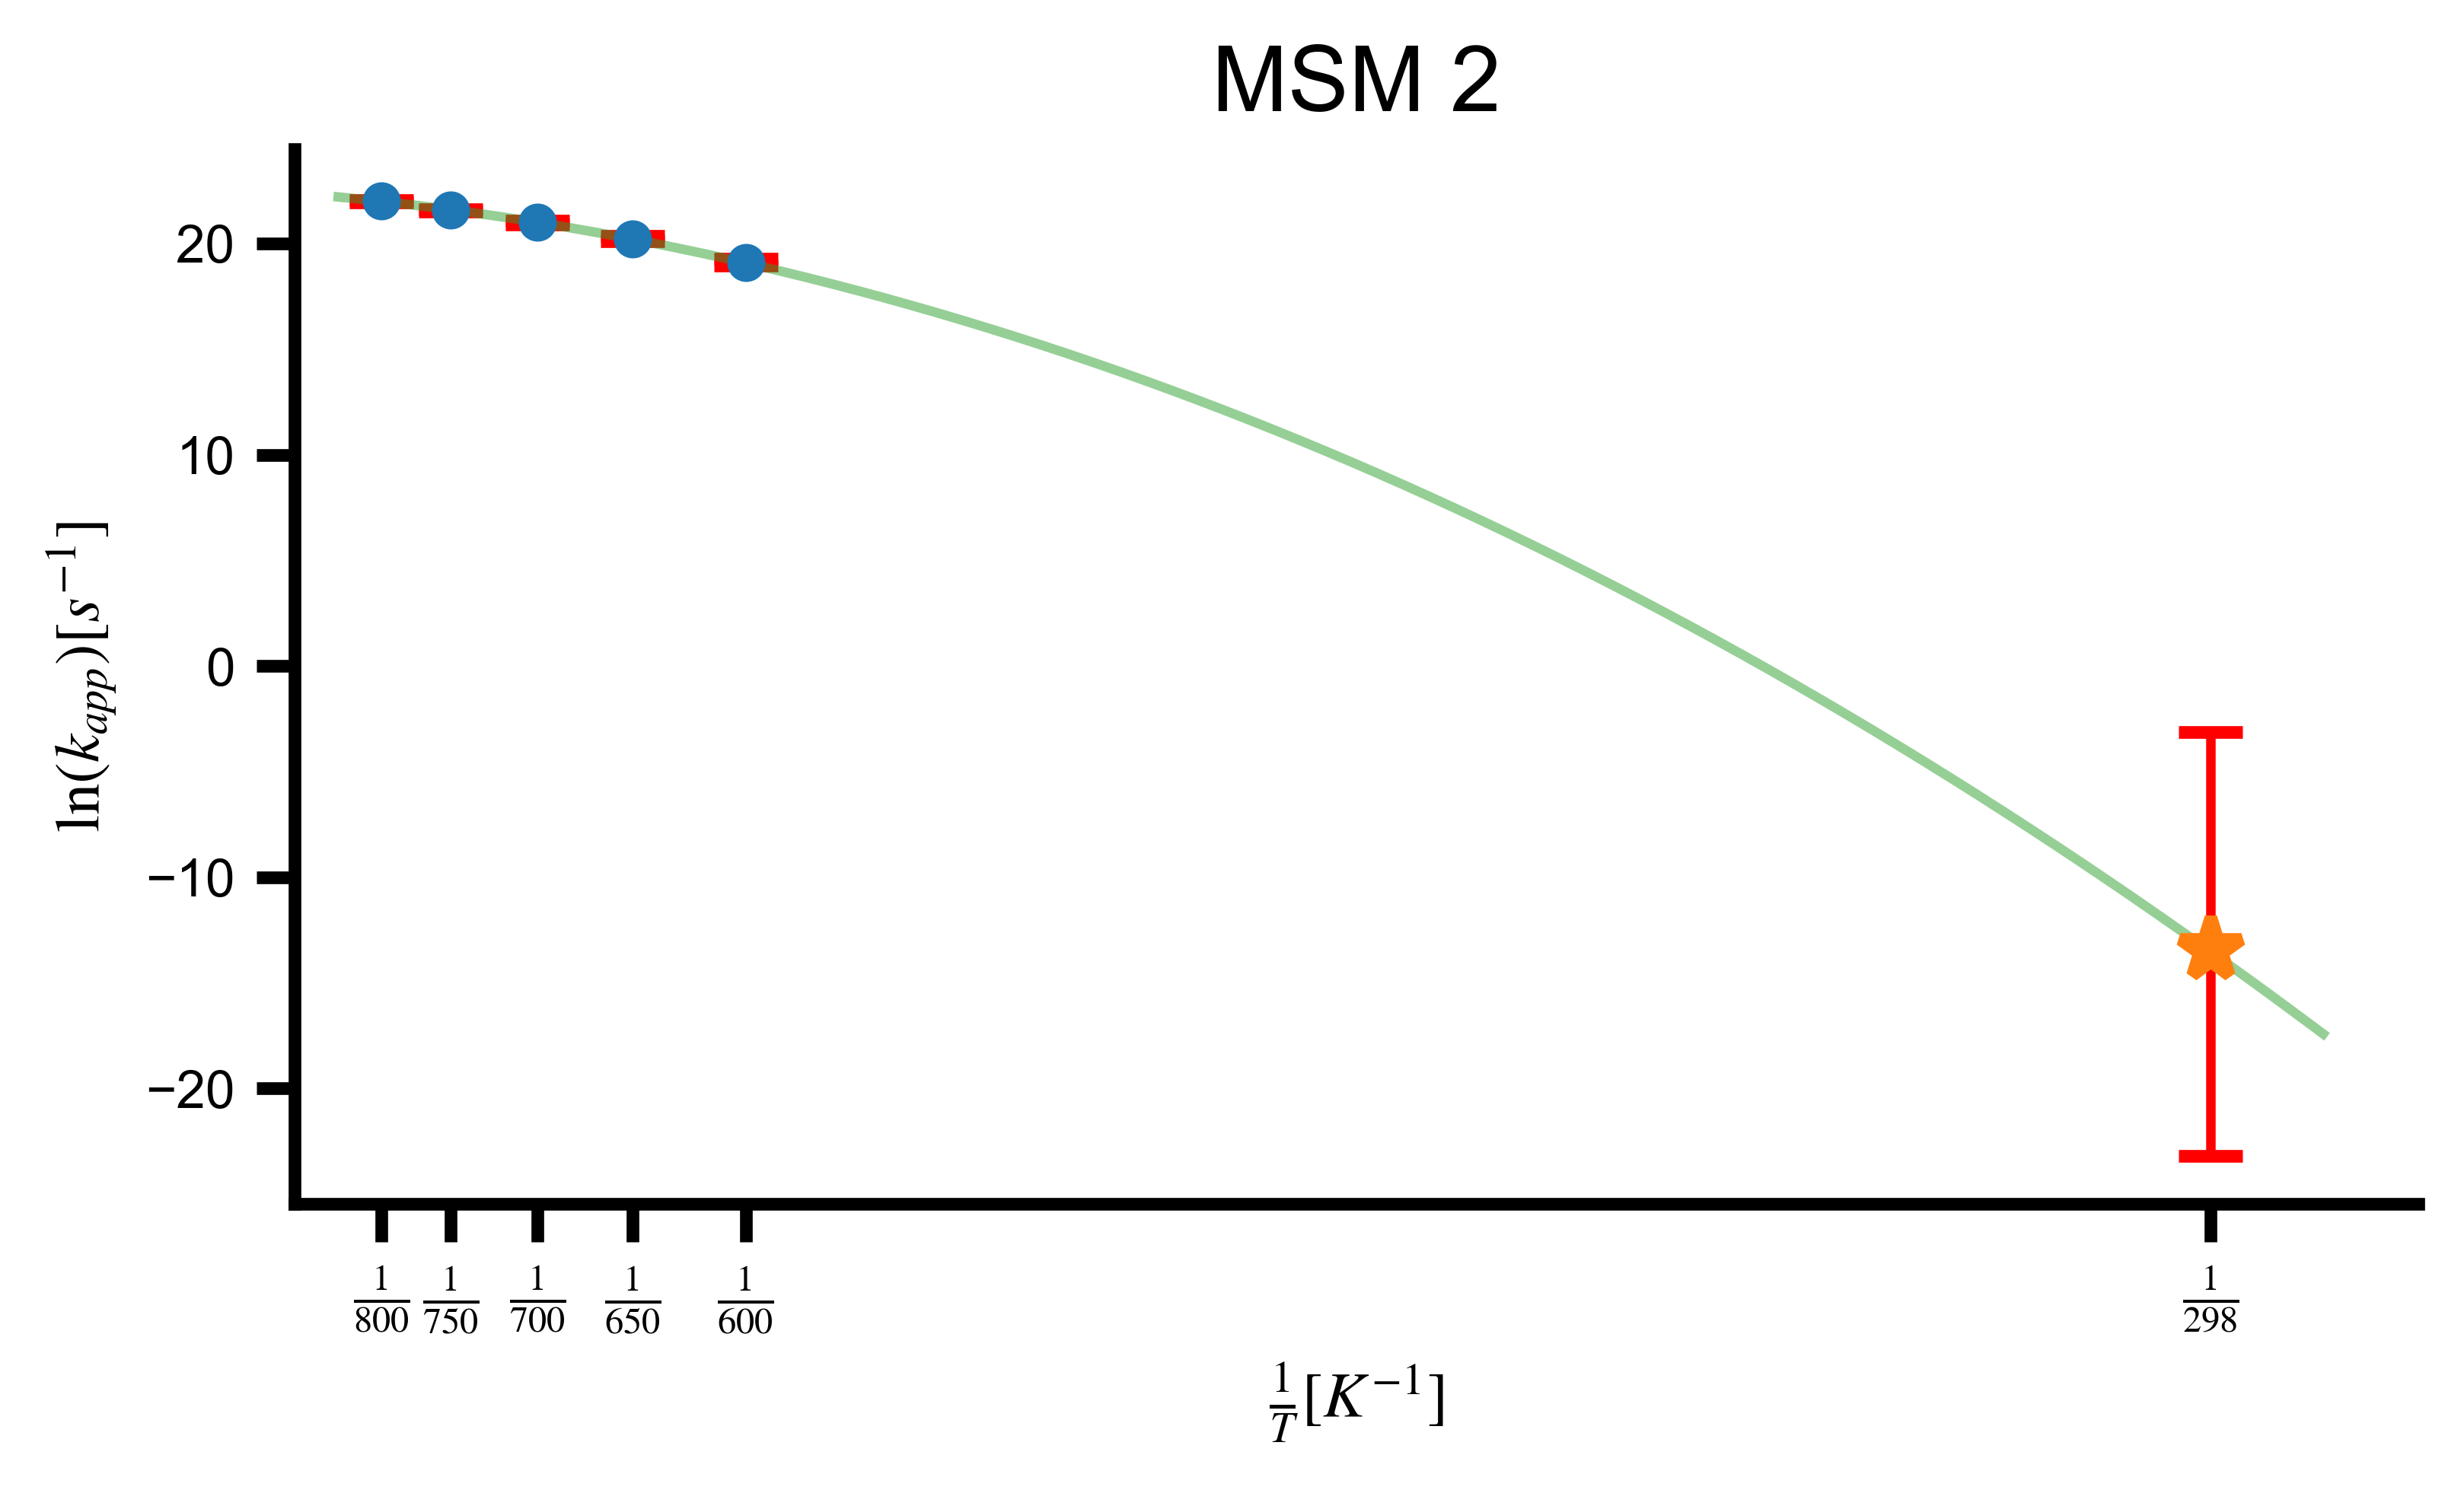

In [11]:
# import numpy as np
# import matplotlib.pyplot as plt

# Define the data as a multiline string
data = """0.00125 22.014 21.952 22.075
0.00133 21.583 21.522 21.646
0.00143 21.013 20.926 21.101
0.00154 20.245 20.116 20.365
0.00167 19.119 18.965 19.278
0.00336 -13.393 -23.183 -3.132"""

T_range=np.arange(0.0012, 0.0035, 0.00001)

# Parse the data
lines = data.split('\n')
x = []
mean = []
lower_bound = []
upper_bound = []

for line in lines:
    cols = line.split()
    x.append(float(cols[0]))
    mean.append(float(cols[1]))
    lower_bound.append(float(cols[2]))
    upper_bound.append(float(cols[3]))

x = np.array(x)
mean = np.array(mean)
lower_bound = np.array(lower_bound)
upper_bound = np.array(upper_bound)

# Calculate the error values
error_lower = mean - lower_bound
error_upper = upper_bound - mean
errors = [error_lower, error_upper]

x_labels = [r'$\frac{1}{800}$', r'$\frac{1}{750}$', r'$\frac{1}{700}$', r'$\frac{1}{650}$', r'$\frac{1}{600}$', r'$\frac{1}{298}$']

# Plot the data with error bars
plt.figure(figsize=(6, 3))

plt.errorbar(x[:-1], mean[:-1], yerr=[error_lower[:-1], error_upper[:-1]], fmt='o', ecolor='red', capsize=5, capthick=2, markeredgewidth=2)
# plot extrapolated point, T=298K
plt.errorbar(x[-1], mean[-1], yerr=[[error_lower[-1]], [error_upper[-1]]], fmt='*', ecolor='red', capsize=5, capthick=2, markeredgewidth=2, markersize=10)


plt.plot(T_range, quadratic_fun(T_range, *mean_res[3]), alpha=0.5)
plt.xlabel(r'$\frac{1}{T}[K^{-1}]$')
plt.ylabel(r'$\ln(k_{app})[s^{-1}]$')

# Set the x-ticks and x-tick labels
plt.xticks(ticks=x, labels=x_labels)
plt.xlim(0.00115, 0.0036)

plt.title('MSM 2')
# plt.grid(True)
# plt.show()
plt.savefig(f'{state}', dpi=1000)

In [12]:
T_range=np.arange(0.0012, 0.0035, 0.00001)
fx_fit = quadratic_fun(T_range, *mean_res[3])
datafitting = np.array([T_range, fx_fit]).T
np.savetxt(f'function_{state}.dat', datafitting, delimiter='\t', fmt = '%10.5f')